In [24]:
BUCKET = 'bud_model'

In [4]:
! pip install split_folders
! pip install pyyaml h5py
! pip install -q kaggle

In [5]:
%matplotlib inline

import os
import zipfile
import splitfolders
import tensorflow as tf

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
! wget --no-check-certificate \
  https://drive.google.com/u/0/uc?id=1KF6dMW9UmhGS1mWQsfFZLp4VFuhXaUhm&export=download
    
os.rename('uc?id=1KF6dMW9UmhGS1mWQsfFZLp4VFuhXaUhm', 'kaggle.json')

In [9]:
! mkdir ~/.kaggle
! cp /home/jupyter/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/home/jupyter/.kaggle’: File exists


In [10]:
! kaggle datasets download -d asdasdasasdas/garbage-classification

 89%|█████████████████████████████████▊    | 73.0M/82.0M [00:00<00:00, 91.6MB/s]
100%|██████████████████████████████████████| 82.0M/82.0M [00:00<00:00, 93.4MB/s]


In [12]:
local_zip = '/home/jupyter/garbage-classification.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('sampah')
zip_ref.close()

splitfolders.ratio('/home/jupyter/sampah/Garbage classification/Garbage classification', '/home/jupyter/sampah/Garbage classification/Klasifikasi gambar', seed=1, ratio=(.9, .1))
base_dir = '/home/jupyter/sampah/Garbage classification/Klasifikasi gambar'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

Copying files: 2527 files [00:00, 8189.46 files/s]


In [13]:
train_kardus = os.path.join(train_dir, 'cardboard')
train_kaca = os.path.join(train_dir, 'glass')
train_logam = os.path.join(train_dir, 'metal')
train_kertas = os.path.join(train_dir, 'paper')
train_plastik = os.path.join(train_dir, 'plastic')
train_sampah = os.path.join(train_dir, 'trash')

val_kardus = os.path.join(validation_dir, 'cardboard')
val_kaca = os.path.join(validation_dir, 'glass')
val_logam = os.path.join(validation_dir, 'metal')
val_kertas = os.path.join(validation_dir, 'paper')
val_plastik = os.path.join(validation_dir, 'plastic')
val_sampah = os.path.join(validation_dir, 'trash')

In [14]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.1,
                    zoom_range=0.1,
                    width_shift_range=0.1,
                    height_shift_range=0.1,
                    validation_split=0.1)

test_datagen = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.1)

In [15]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(300, 300),
        batch_size=16,
        class_mode='categorical',
        subset='training',
        shuffle=True,
        seed=0)

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(300, 300),
        batch_size=16,
        class_mode='categorical',
        subset='validation',
        shuffle=True,
        seed=0)

Found 2046 images belonging to 6 classes.
Found 24 images belonging to 6 classes.


In [16]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

print(labels)

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [17]:
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  return model

model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 32)        9

In [18]:
checkpoint_path = "/home/jupyter/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
riwayat = model.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator,
      callbacks=[cp_callback])

Epoch 1/20
128/128 [==============================] - 108s 835ms/step - loss: 1.7662 - accuracy: 0.2112 - val_loss: 1.6576 - val_accuracy: 0.1667

Epoch 00001: saving model to /home/jupyter/training_1/cp.ckpt
Epoch 2/20
128/128 [==============================] - 108s 844ms/step - loss: 1.6386 - accuracy: 0.2972 - val_loss: 1.6311 - val_accuracy: 0.2917

Epoch 00002: saving model to /home/jupyter/training_1/cp.ckpt
Epoch 3/20
128/128 [==============================] - 106s 824ms/step - loss: 1.4653 - accuracy: 0.4097 - val_loss: 1.4439 - val_accuracy: 0.2500

Epoch 00003: saving model to /home/jupyter/training_1/cp.ckpt
Epoch 4/20
128/128 [==============================] - 108s 842ms/step - loss: 1.3289 - accuracy: 0.4531 - val_loss: 1.2126 - val_accuracy: 0.4583

Epoch 00004: saving model to /home/jupyter/training_1/cp.ckpt
Epoch 5/20
128/128 [==============================] - 107s 832ms/step - loss: 1.2459 - accuracy: 0.4894 - val_loss: 1.2263 - val_accuracy: 0.4583

Epoch 00005: savi

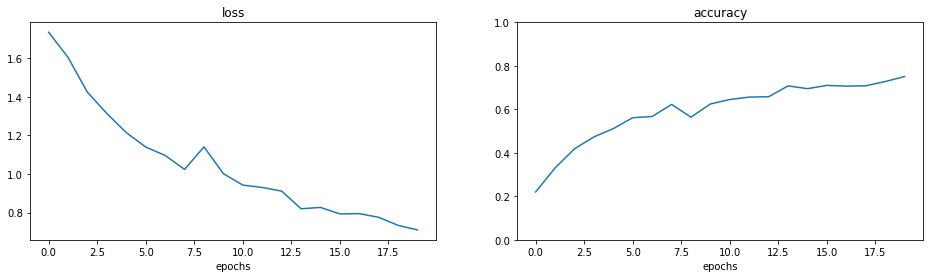

In [22]:
! mkdir ~/plot

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(riwayat.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(riwayat.history["accuracy"])
ax2.set_title("accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.savefig('/home/jupyter/plot/plot1.png', dpi=300, bbox_inches='tight')

plt.show()

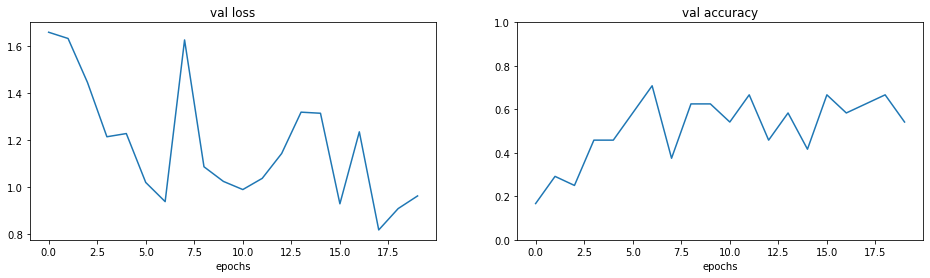

In [25]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(riwayat.history["val_loss"])
ax.set_title("val loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(riwayat.history["val_accuracy"])
ax2.set_title("val accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.savefig('/home/jupyter/plot/plot2.png', dpi=300, bbox_inches='tight')

plt.show()

In [31]:
vgg = keras.models.load_model('model_sampah9.h5')
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0     

In [32]:
inp = vgg.input

new_classification_layer = Dense(6, activation='softmax')

out = new_classification_layer(vgg.layers[-2].output)

model_new = Model(inp, out)

In [33]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 298, 298, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0     

In [34]:
checkpoint_path = "/home/jupyter/training_12/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
riwayat2 = model_new.fit(
      train_generator,
      epochs=20,
      validation_data=validation_generator,
      callbacks=[cp_callback])

Epoch 1/20
128/128 [==============================] - 73s 562ms/step - loss: 5.1361 - accuracy: 0.3189 - val_loss: 2.8252 - val_accuracy: 0.3750

Epoch 00001: saving model to /home/jupyter/training_12/cp.ckpt
Epoch 2/20
128/128 [==============================] - 71s 557ms/step - loss: 1.6862 - accuracy: 0.5843 - val_loss: 1.5478 - val_accuracy: 0.5417

Epoch 00002: saving model to /home/jupyter/training_12/cp.ckpt
Epoch 3/20
128/128 [==============================] - 72s 559ms/step - loss: 0.9885 - accuracy: 0.7345 - val_loss: 1.2291 - val_accuracy: 0.6250

Epoch 00003: saving model to /home/jupyter/training_12/cp.ckpt
Epoch 4/20
128/128 [==============================] - 72s 562ms/step - loss: 0.6750 - accuracy: 0.7968 - val_loss: 1.1580 - val_accuracy: 0.6250

Epoch 00004: saving model to /home/jupyter/training_12/cp.ckpt
Epoch 5/20
128/128 [==============================] - 72s 564ms/step - loss: 0.5351 - accuracy: 0.8301 - val_loss: 1.1246 - val_accuracy: 0.6250

Epoch 00005: savin

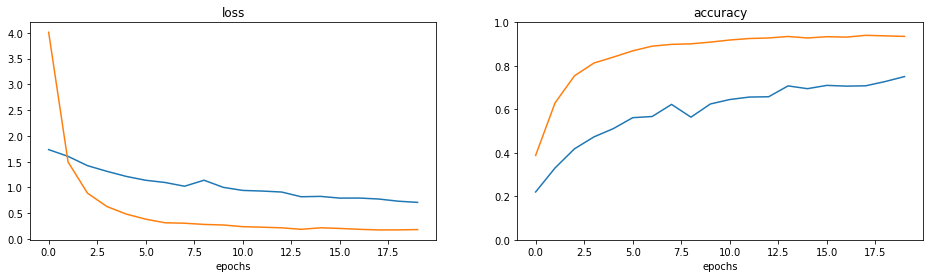

In [35]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(riwayat.history["loss"])
ax.plot(riwayat2.history["loss"])
ax.set_title("loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(riwayat.history["accuracy"])
ax2.plot(riwayat2.history["accuracy"])
ax2.set_title("accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.savefig('/home/jupyter/plot/plot3.png', dpi=300, bbox_inches='tight')

plt.show()

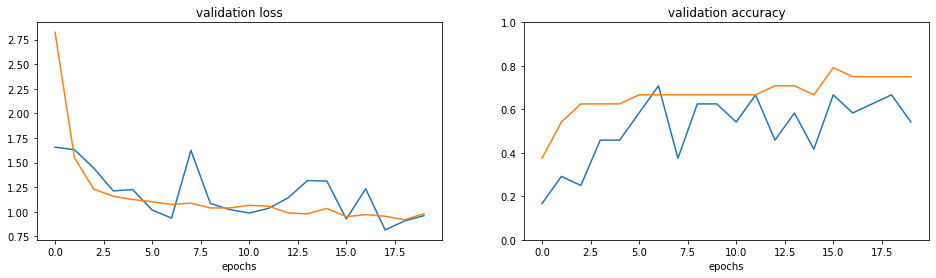

In [36]:
fig = plt.figure(figsize=(16,4))
ax3 = fig.add_subplot(121)
ax3.plot(riwayat.history["val_loss"])
ax3.plot(riwayat2.history["val_loss"])
ax3.set_title("validation loss")
ax3.set_xlabel("epochs")

ax4 = fig.add_subplot(122)
ax4.plot(riwayat.history["val_accuracy"])
ax4.plot(riwayat2.history["val_accuracy"])
ax4.set_title("validation accuracy")
ax4.set_xlabel("epochs")
ax4.set_ylim(0, 1)

plt.savefig('/home/jupyter/plot/plot4.png', dpi=300, bbox_inches='tight')

plt.show()

In [37]:
! mkdir ~/saved_model/pb_model
! mkdir ~/saved_model/h5_model

model_new.save('/home/jupyter/saved_model/pb_model/model_sampah1')
model_new.save('/home/jupyter/saved_model/h5_model/model_sampah1.h5')

mkdir: cannot create directory ‘/home/jupyter/saved_model/pb_model’: No such file or directory
mkdir: cannot create directory ‘/home/jupyter/saved_model/h5_model’: No such file or directory
INFO:tensorflow:Assets written to: /home/jupyter/saved_model/pb_model/model_sampah1/assets


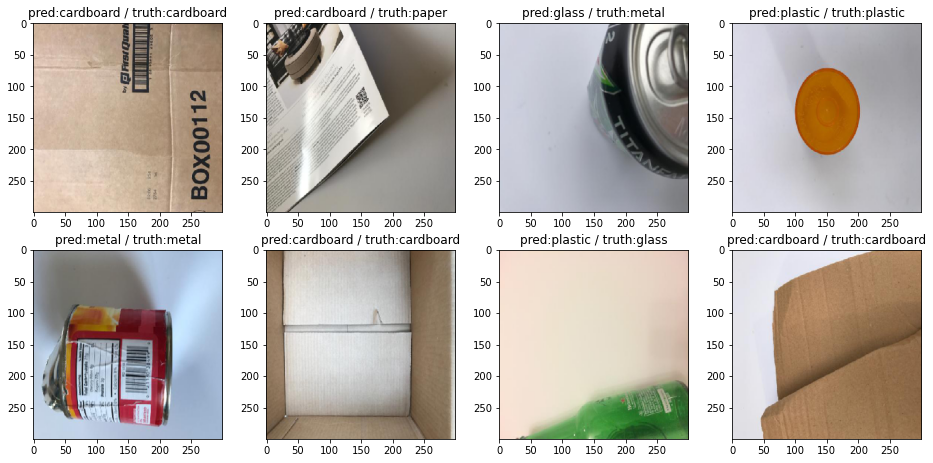

In [38]:
test_x, test_y = validation_generator.__getitem__(1)

preds = model_new.predict(test_x)

plt.figure(figsize=(16, 16))
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.title('pred:%s / truth:%s' % (labels[np.argmax(preds[i])], labels[np.argmax(test_y[i])]))
    plt.imshow(test_x[i])
    
plt.savefig('/home/jupyter/plot/pred.png', dpi=300, bbox_inches='tight')